In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\MOKSHITHA\Downloads\Forecasting_Case_Study_Data.csv")

In [4]:
#data preprocessing
df['Year'] = df['Time'].str.split('_').str[0]
df['Month'] = df['Time'].str.split('_').str[2]
df['Time'] = pd.to_datetime(df['Year'] + '-' + df['Month'], format='%Y-%m')

df.set_index('Time', inplace=True)
df.drop(['Year', 'Month'], axis=1, inplace=True)

In [5]:
data = df.drop(df.index[42:54],axis=0)
data.tail(10)

,Actuals
Time,
2016-09-01,40349.0
2016-10-01,1155664.0
2016-11-01,133602.0
2016-12-01,70494.0
2017-01-01,923024.0
2017-02-01,654624.0
2017-03-01,439447.0
2017-04-01,150382.0
2017-05-01,402642.0


In [6]:
#Normalizing the data

data['Actuals'] = np.log(data['Actuals'])
data.head()

,Actuals
Time,
2014-01-01,12.271144
2014-02-01,10.906011
2014-03-01,12.484840
2014-04-01,11.872207
2014-05-01,12.644147


<AxesSubplot:xlabel='Time'>

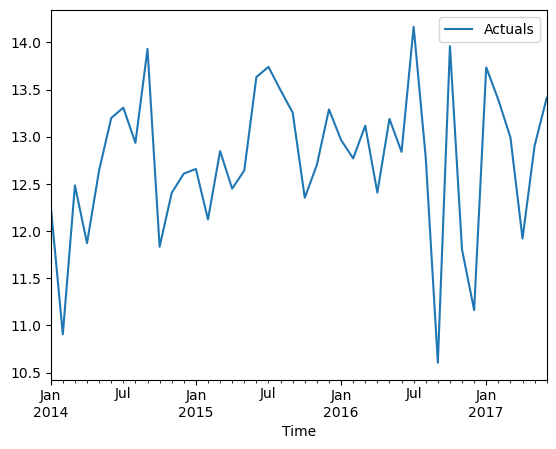

In [7]:
#No seasonality
data.plot()

In [8]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(data['Actuals'])

ADF Test Statistic : -6.228180323620389
p-value : 5.0285217808870556e-08
#Lags Used : 0
Number of Observations Used : 41
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


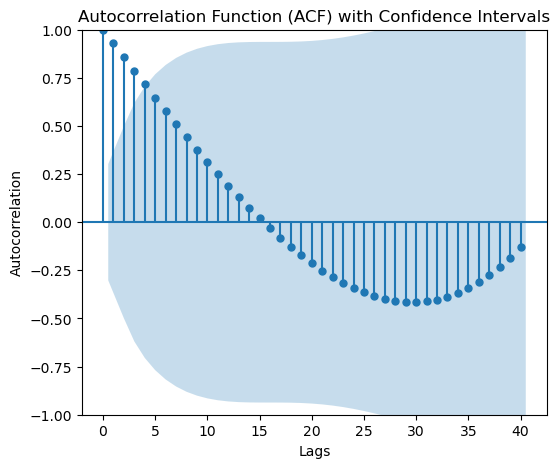

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
data['Numeric_Date'] = data.index.astype(int)
fig, ax = plt.subplots(figsize=(6, 5))
plot_acf(data['Numeric_Date'], lags=40, alpha=0.05, ax=ax)  # Adjust alpha as needed
plt.title('Autocorrelation Function (ACF) with Confidence Intervals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

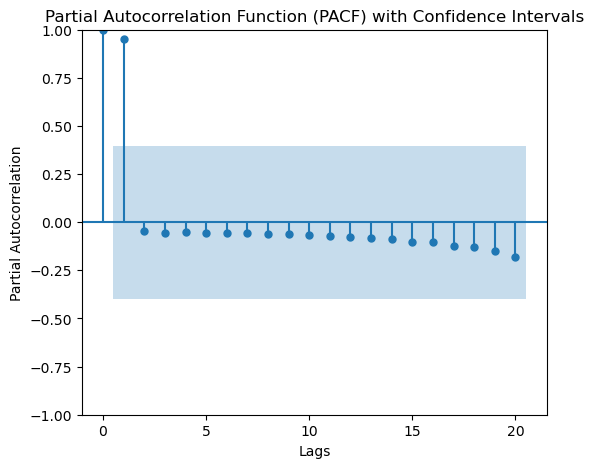

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(6, 5))
plot_pacf(data['Numeric_Date'], lags=20, alpha=0.01, ax=ax)  # Adjust alpha as needed
plt.title('Partial Autocorrelation Function (PACF) with Confidence Intervals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

defining p,q,d components for ARIMA model

component p : Can be determined from PACF curve
Look for the last significant spike in the PACF plot before it drops off to zero or becomes negligible. This can suggest the value of p, which represents the order of the autoregressive (AR) component.
Therefore p can be taken as 1(1 significant spike in the PACF curve)

component q : Can be determined by ACF curve
Look for the last significant spike in the ACF plot before it drops off to zero or becomes negligible. This can suggest the value of q, which represents the order of the moving average (MA) component.
Therefore q can be taken as 3 or 4.Let's try with both.

component d: Since our data is stationary.d can be taken as zero.

In [20]:
import pmdarima as pm
auto_arima = pm.auto_arima(data['Actuals'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [21]:
X_train = data.iloc[:31]
X_test = data.iloc[31:42]
print(len(X_test))
model=ARIMA(X_train['Actuals'],order=(1,0,1))
model=model.fit()
print(len(data))
print(X_test)

11
42
              Actuals         Numeric_Date
Time                                      
2016-08-01  12.777015  1470009600000000000
2016-09-01  10.605322  1472688000000000000
2016-10-01  13.960186  1475280000000000000
2016-11-01  11.802621  1477958400000000000
2016-12-01  11.163283  1480550400000000000
2017-01-01  13.735411  1483228800000000000
2017-02-01  13.391816  1485907200000000000
2017-03-01  12.993272  1488326400000000000
2017-04-01  11.920934  1491004800000000000
2017-05-01  12.905803  1493596800000000000
2017-06-01  13.411578  1496275200000000000


In [22]:
#test predictions
pred=model.predict(start=31,end=41,typ='levels')
print(len(pred))
print(pred)

11
2016-08-01    13.192394
2016-09-01    13.027100
2016-10-01    12.933784
2016-11-01    12.881103
2016-12-01    12.851362
2017-01-01    12.834572
2017-02-01    12.825094
2017-03-01    12.819742
2017-04-01    12.816721
2017-05-01    12.815016
2017-06-01    12.814053
Freq: MS, Name: predicted_mean, dtype: float64


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actuals = data.iloc[31:42,0]
print(len(actuals))
print(len(pred))
mse = mean_squared_error(actuals, pred)
print("Mean Squared Error (MSE):", mse)

mae = mean_absolute_error(actuals,pred)
print('mae:',mae)

11
11
Mean Squared Error (MSE): 1.2212994477306338
mae: 0.8959372898748209


In [24]:
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

mape = calculate_mape(actuals,pred)
print("MAPE:", mape)

MAPE: 7.4997503509194114


In [25]:
prediction=model.predict(start=42,end=53,typ='levels')
print(prediction)

2017-07-01    12.813510
2017-08-01    12.813203
2017-09-01    12.813030
2017-10-01    12.812932
2017-11-01    12.812877
2017-12-01    12.812845
2018-01-01    12.812828
2018-02-01    12.812818
2018-03-01    12.812812
2018-04-01    12.812809
2018-05-01    12.812807
2018-06-01    12.812806
Freq: MS, Name: predicted_mean, dtype: float64


In [26]:
prediction = np.exp(prediction)

In [27]:
print(prediction)

2017-07-01    367144.101710
2017-08-01    367031.459405
2017-09-01    366967.883166
2017-10-01    366931.996465
2017-11-01    366911.738404
2017-12-01    366900.302338
2018-01-01    366893.846336
2018-02-01    366890.201691
2018-03-01    366888.144146
2018-04-01    366886.982577
2018-05-01    366886.326822
2018-06-01    366885.956620
Freq: MS, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Time'>

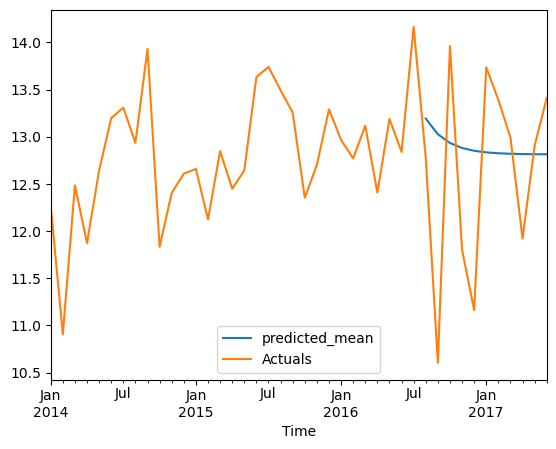

In [28]:
pred.plot(legend=True)
data['Actuals'].plot(legend=True)